In [2]:
import pandas as pd
import numpy as np
import sklearn
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
def load_data(data_path=''):
    train = os.path.join(data_path, "train.csv")
    test = os.path.join(data_path, "test.csv")
    return pd.read_csv(train), pd.read_csv(test)

In [8]:
train_data, test_data = load_data('data')

In [9]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

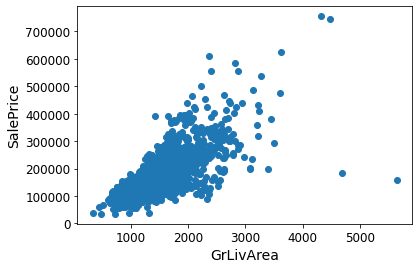

In [11]:
plt.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

In [12]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<12.5)].index)

In [13]:
train_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [14]:
train_data['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [15]:
train_data.drop(columns=['Utilities', 'Street'], inplace=True)
test_data.drop(columns=['Utilities', 'Street'], inplace=True)

In [16]:
#From: got ideas from https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb

def fix_nas(df):
    #Fill na for these column with standard equipment for those - intuition from data description.txt
    df['Functional'] = df['Functional'].fillna('Typ') 
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    df['SaleType'] = df['SaleType'].fillna('Other')
    df['Exterior1st'] = df['Exterior1st'].fillna('Other')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Other')
    
    #None for not exists - intuition from data description.txt
    df['PoolQC'] = df['PoolQC'].fillna('None')
    
    #These two are probably very related
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #Na means No Garage
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        df[col] = df[col].fillna(0)
    
    #Na means No Garage 
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[col] = df[col].fillna('None')
    
    #Na means there's no basement
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].fillna('None')
    
    #Na means no basement, so the measurement is 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
        
    for col in df.select_dtypes(include=[np.object]).columns:
        df[col] = df[col].fillna('None')
        
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)
    
    return df

In [17]:
train_data = fix_nas(train_data)
test_data = fix_nas(test_data)

In [18]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [19]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [20]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 341)

In [21]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [118]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,30), nn.ReLU(),nn.Dropout(0.05),nn.Linear(30, 1))
    
    return net

In [119]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [120]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [121]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [122]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.122572, valid log rmse 0.200536
fold 2, train log rmse 0.116848, valid log rmse 0.184306
fold 3, train log rmse 0.107341, valid log rmse 0.181268
fold 4, train log rmse 0.192956, valid log rmse 0.209822
fold 5, train log rmse 0.118517, valid log rmse 0.199336
5-fold validation: avg train log rmse: 0.131647, avg valid log rmse: 0.195054


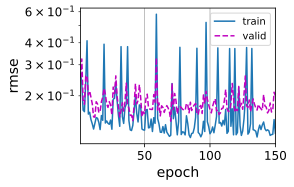

In [123]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [124]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = d2l.numpy(net(test_features))
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.108445


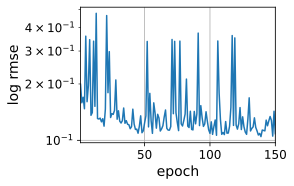

In [125]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)